In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl
import imblearn
import plotly.express as px
from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc
import statsmodels.api as sm
%matplotlib inline


# считываем данные


In [30]:
applications_file = 'Заявки.xlsx'
accounts_file = 'Открытые рс.xlsx'
suspensions_file = 'Блокировки.xlsx'
has_products_file = 'Наличие_кредитного_продукта.xlsx'
report_file = 'спарк.csv'

In [3]:
applications = pd.read_excel(applications_file)
applications.head()

,IdInquiry,ИНН,Дата заявки,Тип организации
0,149105,BYKKBSYFTS,2018-06-18 03:37:00,ЮЛ
1,149106,MIWYERAPTINW,2018-06-18 03:46:00,ИП
2,149107,MIWYERAPTINW,2018-06-18 03:49:00,ИП
3,149109,RXDNYNCXKXRF,2018-06-18 04:12:00,ИП
4,149110,KBTUOUECTSKX,2018-06-18 04:20:00,ИП


In [4]:
open_accounts = pd.read_excel(accounts_file)
open_accounts.head()

,ИНН,Дата открытия,Дата закрытия
0,KTIZMVIQGVVW,2019-09-25,2019-12-18 00:00:00
1,SRCUMJUBNXUM,2019-04-29,2019-06-26 00:00:00
2,KZAGDPVOXANB,2019-06-24,2019-08-29 00:00:00
3,CYCMZJKVLKAZ,2019-10-10,2020-01-30 00:00:00
4,QLQYBUPRBBSJ,2019-10-10,2019-12-24 00:00:00


In [5]:
suspensions = pd.read_excel(suspensions_file)
suspensions.head()

,ИНН,Дата блокировки
0,UWJVWILNVB,2018-06-18
1,DIQZQQEMLN,2018-06-18
2,CECYYCSEAKLP,2018-06-19
3,OCMHZOYWACDN,2018-06-19
4,RDFCTRXYFYHM,2018-06-19


In [6]:
has_products_file = pd.read_excel(has_products_file)
has_products_file.head()

,inn
0,JIFDLDWCKC
1,OXUANITWYSYJ
2,IJWAMIETEASJ
3,VLUUKDPNJBTK
4,WIRLKQYSFY


In [32]:
report_df = pd.read_csv(report_file)
report_df.head()

,ИНН,Дата загрузки заявки,Количество компаний с аналогичным директором в том же регионе,"Компания входит в: Юридические лица, в состав исполнительных органов которых входят дисквалифицированные лица","Количество компаний, зарегистрированных на адресе регистрации Организации по данным сайта ФНС",Количество видов деятельности у Клиента,код основного оквэд,Субъект местонахождения,размер уставного капитал ЮЛ,Чистая прибыль (или убыток) компании,...,19 - Суммируем %% размеры долей учредителей – иностранных ЮЛ из секции,20 - Срок регистрации клиента,21 - КодОКВЭД,21 - ПрВерсОКВЭД,23 - a.\tУправляющая организация – берем данные из секции СвУпрОрг,23 - b. Гендиректор – ФЛ,23 - Учредители и их изменение,23 - Учредители – иностранные компании,23 - Учредители - физлица,История смены сооучредителей
0,JVGAVXQOMXDL,2018-09-24 14:04:47.397,0.0,Нет,NaN,32.0,81.29,GN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,VYSZNCKGGM,2018-11-07 09:28:42.913,2.0,Нет,2.0,13.0,46.72,YS,10000.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ЮЛ: 14.06.2018 0:00:00; ЮЛ: 18.02.2016 0:00:00
2,OAUNBEVXYM,2018-12-19 05:19:50.927,2.0,Нет,12.0,9.0,46.73,ZY,10000.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ЮЛ: 09.10.2018 0:00:00
3,POTUIFVYMPZL,2019-10-25 17:36:45.310,0.0,Нет,NaN,1.0,47.59.1,XT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,KVVWUJYQTVFV,2019-02-04 15:10:23.197,0.0,Нет,NaN,1.0,68.20.2,VM,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
applications_with_open_accounts = pd.merge(applications, open_accounts, how='left', left_on='ИНН', right_on='ИНН')
# посмотрим на инн где есть 2 и более открытых рс
multiple_open_accounts = applications_with_open_accounts[applications_with_open_accounts['ИНН'].duplicated(keep=False)]
multiple_open_accounts = multiple_open_accounts[['ИНН', 'Дата открытия', 'Дата заявки']]
multiple_open_accounts = multiple_open_accounts.sort_values(by=['ИНН', 'Дата открытия'])

multiple_open_accounts

,ИНН,Дата открытия,Дата заявки
261122,AAAAIRYZRC,2019-08-27,2019-08-22 15:06:00
261338,AAAAIRYZRC,2019-08-27,2019-08-22 16:03:00
365156,AAAFBXICUBOO,2019-10-31,2019-10-30 15:35:00
365362,AAAFBXICUBOO,2019-10-31,2019-10-30 16:17:00
309767,AAAHFBJQHKRE,2019-10-03,2019-09-25 11:25:00
...,...,...,...
62649,ZZZYJYKIWJUY,2019-01-28,2018-12-28 10:47:00
338000,ZZZZIBDUCCMF,2019-10-15,2019-10-14 12:00:00
338404,ZZZZIBDUCCMF,2019-10-15,2019-10-14 13:52:00
365463,ZZZZNXTPDFAG,2019-10-31,2019-10-30 16:46:00


In [8]:
# проверим уникально ли инн + дата октытия
multiple_open_accounts['ИНН + Дата открытия'] = multiple_open_accounts['ИНН'].astype(str) + ' ' + multiple_open_accounts['Дата открытия'].astype(str)
multiple_open_accounts['ИНН + Дата открытия'].nunique() == multiple_open_accounts.shape[0]

False

In [9]:
# есть ли у нас много открытий рс на инн - которые имеют разные даты открытия для 1 инн
multiple_open_accounts['ИНН'].nunique() == multiple_open_accounts.shape[0]


False

In [10]:
# посмотрим число строк с с разными датами открытия
multiple_open_dates = applications_with_open_accounts.groupby('ИНН')['Дата открытия'].nunique()

inn_with_multiple_open_dates = multiple_open_dates[multiple_open_dates > 1]

ratio = len(inn_with_multiple_open_dates) / len(applications_with_open_accounts['ИНН'].unique())
print(f"Доля инн с разными датами открытия: {ratio:.2%}")

examples = applications_with_open_accounts[applications_with_open_accounts['ИНН'].isin(inn_with_multiple_open_dates.index)]
examples = examples.sort_values(by=['ИНН', 'Дата открытия'])
examples.head()

Доля инн с разными датами открытия: 1.00%


,IdInquiry,ИНН,Дата заявки,Тип организации,Дата открытия,Дата закрытия
214039,393435,AASJXTWMFL,2019-07-16 09:17:00,ЮЛ,2019-07-18,2019-10-18 00:00:00
214040,393435,AASJXTWMFL,2019-07-16 09:17:00,ЮЛ,2019-07-18,NaN
215027,394476,AASJXTWMFL,2019-07-16 15:45:00,ЮЛ,2019-07-18,2019-10-18 00:00:00
215028,394476,AASJXTWMFL,2019-07-16 15:45:00,ЮЛ,2019-07-18,NaN
215637,395069,AASJXTWMFL,2019-07-17 09:13:00,ЮЛ,2019-07-18,2019-10-18 00:00:00


* есть множество заявок от 1 инн на 1 открытие
* есть инн у которых 

# EDA

In [11]:
# нарисуем график по количеству заявок  в зависимости от месяца в разрезе по типу организации

# Группируем данные по месяцу и типу организации
applications['Дата заявки'] = pd.to_datetime(applications['Дата заявки'])
applications['Month'] = applications['Дата заявки'].dt.to_period('M')

# Агрегируем
data_grouped = applications.groupby(['Month', 'Тип организации']).size().reset_index(name='Count')
data_grouped['Month'] = data_grouped['Month'].astype(str)

fig = px.bar(data_grouped, x='Month', y='Count', color='Тип организации', 
             title='Количество заявок по месяцам в разрезе по типу организации',
             labels={'Month': 'Месяц', 'Count': 'Количество заявок', 'Тип организации': 'Тип организации'})

fig.update_layout(xaxis_title='Месяц', yaxis_title='Количество заявок')
fig.show()

In [12]:
# profile = ProfileReport(applications, title="Profiling Report")
# # profile.to_file("profiling_report.html")
# profile

# сбор данных

In [13]:
applications

,IdInquiry,ИНН,Дата заявки,Тип организации,Month
0,149105,BYKKBSYFTS,2018-06-18 03:37:00,ЮЛ,2018-06
1,149106,MIWYERAPTINW,2018-06-18 03:46:00,ИП,2018-06
2,149107,MIWYERAPTINW,2018-06-18 03:49:00,ИП,2018-06
3,149109,RXDNYNCXKXRF,2018-06-18 04:12:00,ИП,2018-06
4,149110,KBTUOUECTSKX,2018-06-18 04:20:00,ИП,2018-06
...,...,...,...,...,...
387230,622690,KQCLSYJDIH,2019-12-14 14:26:00,ЮЛ,2019-12
387231,622691,KGIMRLIRFD,2019-12-14 14:30:00,ЮЛ,2019-12
387232,622692,MMHDXFQTHESN,2019-12-14 14:39:00,ИП,2019-12
387233,622693,NZVWQJIOPC,2019-12-14 14:39:00,ЮЛ,2019-12


# добавление данных

In [14]:
# добавим инфо о числе заявок до даты
applications['Дата заявки'] = pd.to_datetime(applications['Дата заявки'])
applications = applications.sort_values(by=['ИНН', 'Дата заявки'])

applications['Заявки до даты'] = applications.groupby('ИНН')['Дата заявки'].cumcount()

applications.head()

,IdInquiry,ИНН,Дата заявки,Тип организации,Month,Заявки до даты
229351,441465,AAAAIRYZRC,2019-08-22 15:06:00,ЮЛ,2019-08,0
229533,441672,AAAAIRYZRC,2019-08-22 16:03:00,ЮЛ,2019-08,1
356530,587893,AAADCVZNUR,2019-11-26 09:20:00,ЮЛ,2019-11,0
322404,549280,AAAFBXICUBOO,2019-10-30 15:35:00,ИП,2019-10,0
322584,549481,AAAFBXICUBOO,2019-10-30 16:17:00,ИП,2019-10,1


In [15]:
#  проверим есть ли у нас заявки с одинаковыми инн и датами
applications = applications.merge(open_accounts[['ИНН', 'Дата открытия']], on='ИНН', how='left', suffixes=('', '_open'))
applications['Дата заявки'] = pd.to_datetime(applications['Дата заявки'])
applications['Дата открытия'] = pd.to_datetime(applications['Дата открытия'])

applications['Продукт открыт ранее'] = applications['Дата открытия'] < applications['Дата заявки']

# заполним пропуски в столбце 'Продукт открыт ранее' значением False
applications['Продукт открыт ранее'] = applications['Продукт открыт ранее'].fillna(False)

applications.head()

,IdInquiry,ИНН,Дата заявки,Тип организации,Month,Заявки до даты,Дата открытия,Продукт открыт ранее
0,441465,AAAAIRYZRC,2019-08-22 15:06:00,ЮЛ,2019-08,0,2019-08-27,False
1,441672,AAAAIRYZRC,2019-08-22 16:03:00,ЮЛ,2019-08,1,2019-08-27,False
2,587893,AAADCVZNUR,2019-11-26 09:20:00,ЮЛ,2019-11,0,2019-11-28,False
3,549280,AAAFBXICUBOO,2019-10-30 15:35:00,ИП,2019-10,0,2019-10-31,False
4,549481,AAAFBXICUBOO,2019-10-30 16:17:00,ИП,2019-10,1,2019-10-31,False


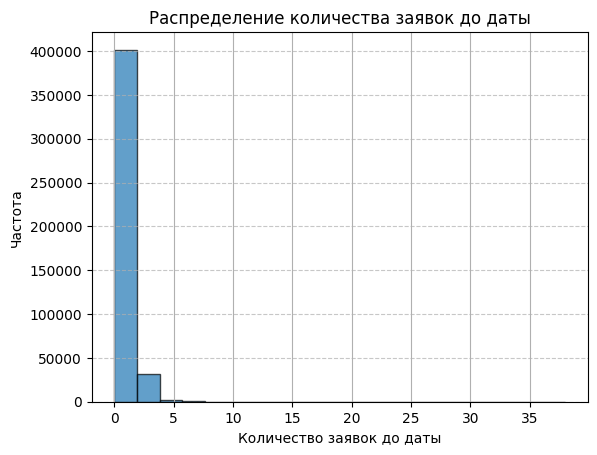

In [16]:

applications['Заявки до даты'].hist(bins=20, edgecolor='black', alpha=0.7)
plt.title('Распределение количества заявок до даты')
plt.xlabel('Количество заявок до даты')
plt.ylabel('Частота')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [17]:
# Convert 'Дата открытия' and 'Дата закрытия' to datetime, coercing errors (out-of-bounds become NaT)
open_accounts['Дата открытия'] = pd.to_datetime(open_accounts['Дата открытия'], errors='coerce')
open_accounts['Дата закрытия'] = pd.to_datetime(open_accounts['Дата закрытия'], errors='coerce')

# Filter out rows with NaT in either date column (invalid/out-of-bounds dates)
open_accounts = open_accounts[
    open_accounts['Дата открытия'].notna() & open_accounts['Дата закрытия'].notna()
]

# Add a column to indicate if a product was previously closed for this ИНН
applications = applications.merge(open_accounts[['ИНН', 'Дата закрытия']], on='ИНН', how='left', suffixes=('', '_close'))
applications['Дата закрытия'] = pd.to_datetime(applications['Дата закрытия'], errors='coerce')

# Check if a product was closed before the application date
applications['Продукт ранее закрыт'] = applications['Дата закрытия'] < applications['Дата заявки']

# Fill NaN values with False (no product closed earlier)
applications['Продукт ранее закрыт'] = applications['Продукт ранее закрыт'].fillna(False)

# Display the updated dataframe
applications.head()

,IdInquiry,ИНН,Дата заявки,Тип организации,Month,Заявки до даты,Дата открытия,Продукт открыт ранее,Дата закрытия,Продукт ранее закрыт
0,441465,AAAAIRYZRC,2019-08-22 15:06:00,ЮЛ,2019-08,0,2019-08-27,False,NaT,False
1,441672,AAAAIRYZRC,2019-08-22 16:03:00,ЮЛ,2019-08,1,2019-08-27,False,NaT,False
2,587893,AAADCVZNUR,2019-11-26 09:20:00,ЮЛ,2019-11,0,2019-11-28,False,NaT,False
3,549280,AAAFBXICUBOO,2019-10-30 15:35:00,ИП,2019-10,0,2019-10-31,False,NaT,False
4,549481,AAAFBXICUBOO,2019-10-30 16:17:00,ИП,2019-10,1,2019-10-31,False,NaT,False


In [18]:
applications['Продукт открыт ранее'].mean(),applications['Продукт ранее закрыт'].mean()

(np.float64(0.23638611059544778), np.float64(0.010291634028950598))

In [19]:
has_products_file['has_products'] = True  

# Ensure the column name matches for merging
has_products_file_renamed = has_products_file.rename(columns={'inn': 'ИНН'})

applications = applications.merge(
	has_products_file_renamed[['ИНН', 'has_products']],
	on='ИНН', how='left'
)

# Fill NaN values with False (no products for this ИНН)
applications['has_products'] = applications['has_products'].fillna(False).infer_objects(copy=False)

# Display the updated dataframe
applications.head()

/var/folders/dk/6t0bvj8n45q61w7_l1c3tqn00000gn/T/ipykernel_14288/2757267331.py:11: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



,IdInquiry,ИНН,Дата заявки,Тип организации,Month,Заявки до даты,Дата открытия,Продукт открыт ранее,Дата закрытия,Продукт ранее закрыт,has_products
0,441465,AAAAIRYZRC,2019-08-22 15:06:00,ЮЛ,2019-08,0,2019-08-27,False,NaT,False,False
1,441672,AAAAIRYZRC,2019-08-22 16:03:00,ЮЛ,2019-08,1,2019-08-27,False,NaT,False,False
2,587893,AAADCVZNUR,2019-11-26 09:20:00,ЮЛ,2019-11,0,2019-11-28,False,NaT,False,False
3,549280,AAAFBXICUBOO,2019-10-30 15:35:00,ИП,2019-10,0,2019-10-31,False,NaT,False,False
4,549481,AAAFBXICUBOO,2019-10-30 16:17:00,ИП,2019-10,1,2019-10-31,False,NaT,False,False


In [20]:
applications.has_products.mean()

np.float64(0.03583082858652365)

## присоединим suspensions

In [21]:
# Merge suspensions data to include information about blocked accounts
applications = applications.merge(suspensions[['ИНН', 'Дата блокировки']], on='ИНН', how='left')

# Convert 'Дата блокировки' to datetime format
applications['Дата блокировки'] = pd.to_datetime(applications['Дата блокировки'], errors='coerce')

# Display the updated dataframe
applications.head()

,IdInquiry,ИНН,Дата заявки,Тип организации,Month,Заявки до даты,Дата открытия,Продукт открыт ранее,Дата закрытия,Продукт ранее закрыт,has_products,Дата блокировки
0,441465,AAAAIRYZRC,2019-08-22 15:06:00,ЮЛ,2019-08,0,2019-08-27,False,NaT,False,False,NaT
1,441672,AAAAIRYZRC,2019-08-22 16:03:00,ЮЛ,2019-08,1,2019-08-27,False,NaT,False,False,NaT
2,587893,AAADCVZNUR,2019-11-26 09:20:00,ЮЛ,2019-11,0,2019-11-28,False,NaT,False,False,NaT
3,549280,AAAFBXICUBOO,2019-10-30 15:35:00,ИП,2019-10,0,2019-10-31,False,NaT,False,False,NaT
4,549481,AAAFBXICUBOO,2019-10-30 16:17:00,ИП,2019-10,1,2019-10-31,False,NaT,False,False,NaT


In [23]:
# создаем целевую переменную - что был заблокирован продукт в интервале 6 месяцев после даты заявки
applications['target'] = applications.apply(
    lambda x: 1 if (x['Дата блокировки'] >= x['Дата заявки']) and (x['Дата блокировки'] <= x['Дата заявки'] + pd.DateOffset(months=6)) else 0,
    axis=1
)

# Display the updated dataframe
applications.head()


,IdInquiry,ИНН,Дата заявки,Тип организации,Month,Заявки до даты,Дата открытия,Продукт открыт ранее,Дата закрытия,Продукт ранее закрыт,has_products,Дата блокировки,target
0,441465,AAAAIRYZRC,2019-08-22 15:06:00,ЮЛ,2019-08,0,2019-08-27,False,NaT,False,False,NaT,0
1,441672,AAAAIRYZRC,2019-08-22 16:03:00,ЮЛ,2019-08,1,2019-08-27,False,NaT,False,False,NaT,0
2,587893,AAADCVZNUR,2019-11-26 09:20:00,ЮЛ,2019-11,0,2019-11-28,False,NaT,False,False,NaT,0
3,549280,AAAFBXICUBOO,2019-10-30 15:35:00,ИП,2019-10,0,2019-10-31,False,NaT,False,False,NaT,0
4,549481,AAAFBXICUBOO,2019-10-30 16:17:00,ИП,2019-10,1,2019-10-31,False,NaT,False,False,NaT,0


In [24]:
# нарисуем динамику таргета в разрезе по типу организации
# Группируем данные по месяцу и типу организации как долю от числа заявок по типу организации

# посчитаем долю таргета по типу организации
applications['Month'] = applications['Дата заявки'].dt.to_period('M')

data_grouped = applications.groupby(['Month', 'Тип организации']).agg(
    total=('target', 'size'),
    target_ratio=('target', 'mean')
).reset_index()

data_grouped['Month'] = data_grouped['Month'].astype(str)

# построим график
fig = px.line(
    data_grouped,
    x='Month',
    y='target_ratio',
    color='Тип организации',
    title='Динамика таргета в разрезе по типу организации',
    labels={'Month': 'Месяц', 'target_ratio': 'Доля таргета', 'Тип организации': 'Тип организации'}
)

fig.update_layout(xaxis_title='Месяц', yaxis_title='Доля таргета')
fig.show()

* сразу видим проблему - у нас сезонность в данных, но меньше двух лет. мы не можем использовать скользящее среднее для учета сезонности
* добавим флаг, что это выходной
* добавим флаг, что это праздничный день


In [26]:
applications.columns

Index(['IdInquiry', 'ИНН', 'Дата заявки', 'Тип организации', 'Month',
       'Заявки до даты', 'Дата открытия', 'Продукт открыт ранее',
       'Дата закрытия', 'Продукт ранее закрыт', 'has_products',
       'Дата блокировки', 'target'],
      dtype='object')

In [36]:
target = applications['target']
features = applications[[
    'Тип организации',
    'has_products',
    'Продукт открыт ранее',
    'Продукт ранее закрыт',
    'Заявки до даты'
]].copy()
# преобразуем булевы в 0 и 1
features = pd.get_dummies(features, columns=['Тип организации'], drop_first=True)

features['has_products'] = features['has_products'].astype(int)
features['Продукт открыт ранее'] = features['Продукт открыт ранее'].astype(int)
features['Продукт ранее закрыт'] = features['Продукт ранее закрыт'].astype(int)
features['Тип организации_ЮЛ'] = features['Тип организации_ЮЛ'].astype(int)

# преобразуем тип организации в числовой
# создаем дамми переменные
features

,has_products,Продукт открыт ранее,Продукт ранее закрыт,Заявки до даты,Тип организации_ЮЛ
0,0,0,0,0,1
1,0,0,0,1,1
2,0,0,0,0,1
3,0,0,0,0,0
4,0,0,0,1,0
...,...,...,...,...,...
453779,0,0,0,0,0
453780,0,0,0,0,0
453781,0,0,0,1,0
453782,0,0,0,0,0


In [34]:
# Add polynomial encoding (4 series per year) for 'Дата заявки'
applications['Дата заявки'] = pd.to_datetime(applications['Дата заявки'])
applications['Year'] = applications['Дата заявки'].dt.year
applications['DayOfYear'] = applications['Дата заявки'].dt.dayofyear

# Polynomial encoding (4 series per year)
applications['Poly1'] = np.sin(2 * np.pi * applications['DayOfYear'] / 91.25)
applications['Poly2'] = np.cos(2 * np.pi * applications['DayOfYear'] / 91.25)
applications['Poly3'] = np.sin(4 * np.pi * applications['DayOfYear'] / 91.25)
applications['Poly4'] = np.cos(4 * np.pi * applications['DayOfYear'] / 91.25)

In [35]:
# Add trigonometric encoding for time within 'Дата заявки'
applications['Hour'] = applications['Дата заявки'].dt.hour
applications['Minute'] = applications['Дата заявки'].dt.minute
applications['Second'] = applications['Дата заявки'].dt.second

# Convert time to seconds since midnight
time_in_seconds = applications['Hour'] * 3600 + applications['Minute'] * 60 + applications['Second']
seconds_in_day = 24 * 3600

# Trigonometric encoding
applications['TimeSin'] = np.sin(2 * np.pi * time_in_seconds / seconds_in_day)
applications['TimeCos'] = np.cos(2 * np.pi * time_in_seconds / seconds_in_day)

In [36]:
# Add weekday encoding for 'Дата заявки'
applications['Weekday'] = applications['Дата заявки'].dt.weekday
applications = pd.get_dummies(applications, columns=['Weekday'], prefix='Weekday', drop_first=True)

In [37]:
applications

,IdInquiry,ИНН,Дата заявки,Тип организации,Month,Заявки до даты,Дата открытия,Продукт открыт ранее,Дата закрытия,Продукт ранее закрыт,...,Minute,Second,TimeSin,TimeCos,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6
0,441465,AAAAIRYZRC,2019-08-22 15:06:00,ЮЛ,2019-08,0,2019-08-27,False,NaT,False,...,6,0,-7.253744e-01,-0.688355,False,False,True,False,False,False
1,441672,AAAAIRYZRC,2019-08-22 16:03:00,ЮЛ,2019-08,1,2019-08-27,False,NaT,False,...,3,0,-8.724960e-01,-0.488621,False,False,True,False,False,False
2,587893,AAADCVZNUR,2019-11-26 09:20:00,ЮЛ,2019-11,0,2019-11-28,False,NaT,False,...,20,0,6.427876e-01,-0.766044,True,False,False,False,False,False
3,549280,AAAFBXICUBOO,2019-10-30 15:35:00,ИП,2019-10,0,2019-10-31,False,NaT,False,...,35,0,-8.064446e-01,-0.591310,False,True,False,False,False,False
4,549481,AAAFBXICUBOO,2019-10-30 16:17:00,ИП,2019-10,1,2019-10-31,False,NaT,False,...,17,0,-9.006982e-01,-0.434445,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
453779,232404,ZZZYJYKIWJUY,2018-12-28 10:47:00,ИП,2018-12,0,2019-01-28,False,2019-04-24,False,...,47,0,3.131638e-01,-0.949699,False,False,False,True,False,False
453780,521067,ZZZZIBDUCCMF,2019-10-14 12:00:00,ИП,2019-10,0,2019-10-15,False,NaT,False,...,0,0,-3.216245e-16,-1.000000,False,False,False,False,False,False
453781,521485,ZZZZIBDUCCMF,2019-10-14 13:52:00,ИП,2019-10,1,2019-10-15,False,NaT,False,...,52,0,-4.694716e-01,-0.882948,False,False,False,False,False,False
453782,549591,ZZZZNXTPDFAG,2019-10-30 16:46:00,ИП,2019-10,0,2019-10-31,False,NaT,False,...,46,0,-9.483237e-01,-0.317305,False,True,False,False,False,False


Optimization terminated successfully.
         Current function value: 0.347778
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:               317648
Model:                          Logit   Df Residuals:                   317642
Method:                           MLE   Df Model:                            5
Date:                Fri, 23 May 2025   Pseudo R-squ.:                 0.03160
Time:                        23:00:14   Log-Likelihood:            -1.1047e+05
converged:                       True   LL-Null:                   -1.1408e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -2.4905      0.010   -240.073      0.000      -2.511      -2.47

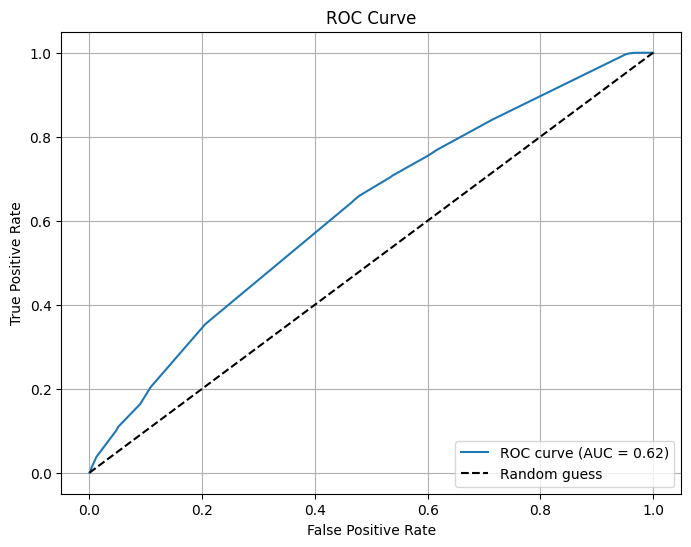

ROC AUC: 0.62
Gini Coefficient: 0.24


In [38]:

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# Fit logistic regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

# Evaluate variable significance using statsmodels
X_train_sm = sm.add_constant(X_train)  # Add constant for intercept
logit_model = sm.Logit(y_train, X_train_sm)
result = logit_model.fit()
print(result.summary())

# Predict probabilities and calculate ROC AUC
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Calculate Gini coefficient
gini = 2 * roc_auc - 1

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

print(f"ROC AUC: {roc_auc:.2f}")
print(f"Gini Coefficient: {gini:.2f}")

ROC AUC: 0.62
Gini Coefficient: 0.24